In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
import cv2
from tensorflow import keras
import tensorflow as tf
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K

In [51]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from annoy import AnnoyIndex
from google.colab import files

In [4]:
import numpy as np
import scipy.misc
import cv2
import numpy.random as rng
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import skimage.transform as skTrans
import nibabel as nib 
from sklearn.model_selection import train_test_split
import math
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
!unzip "/content/gdrive/MyDrive/Data/GBM_T1-AX-POST-GAD.zip"
!unzip "/content/gdrive/MyDrive/Data/LGG_T1-AX-POST-GAD.zip"
dicom_directory_LGG = '/content/GBM_T1-AX-POST-GAD/*'
dicom_directory_GBM = '/content/LGG_T1-AX-POST-GAD/*'
nifti_directory = "/content/gdrive/MyDrive/Data/nifti"
convert_directory(dicom_directory_LGG, nifti_directory, compression=True, reorient=True)
convert_directory(dicom_directory_GBM, nifti_directory, compression=True, reorient=True)

In [ ]:
!unzip "/content/gdrive/MyDrive/Data/GBM_T1-AX-POST-GAD.zip"
!unzip "/content/gdrive/MyDrive/Data/LGG_T1-AX-POST-GAD.zip"

In [12]:
ff1 = glob.glob('/content/GBM_T1-AX-POST-GAD/*')
ff2 = glob.glob('/content/LGG_T1-AX-POST-GAD/*')

In [ ]:
ff = glob.glob(nifti_directory+"/*")

In [ ]:
def display_slices(scan):
  slicenum = len(scan)
  plt.figure(figsize=[10,230])
  for n in range(slicenum):
    img = scan[n]
    plt.subplot(23,1,n+1)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(n+1,fontsize='40')
    plt.imshow(img, cmap='gray')

In [8]:
def load_slices(file_path, dim, num):
  slices = []
  t1_img = nib.load(file_path)
  t1_arr = t1_img.get_fdata()
  if t1_arr.shape[0] >= dim and t1_arr.shape[2] >= num:
      half = num//2
      n = (t1_arr.shape[2])//2
      t1_arr = t1_arr[:,:,n-half:n+half,]
      t1_arr = skTrans.resize(t1_arr, (dim, dim, num), order=1, preserve_range=True)
      for i in range(t1_arr[:,:,:,].shape[2]):
        slices.append((t1_arr[:,:,i]))
  return slices

In [9]:
def load_images(ff,dim,num):
  images = []
  t1_img = None
  t1_arr = None
  for f in range(len(ff)):
    images = images + load_slices(ff[f],dim,num)
  return images

In [10]:
def image_preprocessing(images):
  dim = images[0].shape[0]
  images = np.asarray(images)
  images = images.reshape(-1, dim,dim,1)

  m = np.max(images)
  mi = np.min(images)

  images = (images - mi) / (m - mi)
  np.min(images), np.max(images)

  temp = np.zeros([len(images),dim+4,dim+4,1])
  temp[:,4:,4:,:] = images
  images = temp
  return images

In [13]:
images = image_preprocessing(load_images(ff1,256,20) + load_images(ff2,256,20))
#images = image_preprocessing(load_images(ff,256,20))

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,
                                                             images,
                                                             test_size=0.3,
                                                             random_state=13)

In [ ]:
print("Dataset (images) shape: {shape}".format(shape=images.shape))

Dataset (images) shape: (2040, 260, 260, 1)


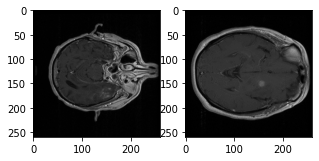

In [ ]:
plt.figure(figsize=[5,5])

plt.subplot(121)
curr_img = np.reshape(train_X[36], (260,260))
plt.imshow(curr_img, cmap='gray')

plt.subplot(122)
curr_img = np.reshape(valid_X[80], (260,260))
plt.imshow(curr_img, cmap='gray')

In [15]:
batch_size = 32
epochs = 100
inChannel = 1
x, y = 260, 260

#INPUT LAYER
input_layer = Input(shape = (x, y, inChannel))

In [16]:
#ENCODING ARCHITECTURE
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer) 
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) 
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) 
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) 
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) 
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
latent_view = BatchNormalization()(conv3)

In [17]:
#DECODING ARCHITECTURE
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(latent_view) 
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
up1 = UpSampling2D((2,2))(conv4) 
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) 
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
up2 = UpSampling2D((2,2))(conv5) 
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) 

In [ ]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [ ]:
autoencoder.summary()

In [ ]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

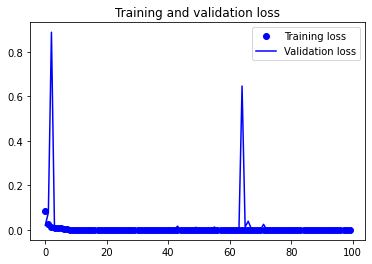

In [ ]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
autoencoder = autoencoder.save_weights('autoencoder_mri.h5')

encoder = Model(input_layer, latent_view)
encoder.compile(loss='mean_squared_error', optimizer = RMSprop())
encoder.save('encoder_mri.h5')

decoder = Model(latent_view, output_layer)
decoder.compile(loss='mean_squared_error', optimizer = RMSprop())
decoder.save('decoder_mri.h5')

print( os.getcwd() )

from google.colab import files
files.download( "autoencoder_mri.h5" )
files.download( "encoder_mri.h5" )
files.download( "decoder_mri.h5" )

/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
autoencoder = Model(input_layer, output_layer)
autoencoder.load_weights('/content/gdrive/MyDrive/Data/Weights/autoencoder_mri.h5')

In [48]:
def PSNR(valid_X, valid_ground, noisy=False):
  if noisy:
    [a,b,c,d]= np.shape(valid_X)
    mean = 0
    sigma = 0.03
    gauss = np.random.normal(mean,sigma,(a,b,c,d))
    noisy_images = valid_X + gauss
    pred = autoencoder.predict(noisy_images)
    mse =  np.mean((valid_X - pred) ** 2)
    psnr = 20 * math.log10( 1.0 / math.sqrt(mse))
    images = noisy_images

    text1 = "Noisy Test Images"
    text2 = "Reconstruction of Test Images, PSNR: {psnr}".format(psnr=np.round(psnr,2))
  else:
    pred = autoencoder.predict(valid_X)  
    mse =  np.mean((valid_X - pred) ** 2)
    psnr = 20 * math.log10( 1.0 / math.sqrt(mse))
    images = valid_X

    text1 = "Test Images"
    text2 = "Reconstruction of Test Images, PSNR: {psnr}".format(psnr=np.round(psnr,2))

  fig, big_axes = plt.subplots( figsize=(30, 13) , nrows=2, ncols=1, sharey=True) 

  for row, big_ax in enumerate(big_axes, start=1):
    if row == 1:
      big_ax.set_title(text1, fontsize=20)
    if row == 2:
      big_ax.set_title(text2, fontsize=20)
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax._frameon = False
  
  for i in range(0,5):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(images[i, ..., 0], cmap='gray')
  for i in range(0,5):
    ax = fig.add_subplot(2, 5, i+6)
    ax.imshow(pred[i, ..., 0], cmap='gray')

  fig.set_facecolor('w')
  plt.tight_layout()
  plt.show()

In [ ]:
PSNR(valid_X, valid_ground, False)

In [ ]:
PSNR(valid_X, valid_ground, True)

In [88]:
def SSIM(slices, index):
  img = slices[index]
  noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
  rng = np.random.default_rng()
  noise[rng.random(size=noise.shape) > 0.5] *= -1

  img_pred = autoencoder.predict(slices)[index]
  slices_noise = slices + noise
  img_noise = slices_noise[index]
  img_noisy_pred = autoencoder.predict(slices_noise)[index]

  tmp = np.squeeze(img)
  tmp_pred = np.squeeze(img_pred)
  tmp_noise = np.squeeze(img_noise)
  tmp_noisy_pred =  np.squeeze(img_noisy_pred)


  fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8), sharex=True, sharey=True)
  ax = axes.ravel()

  mse_none = mean_squared_error(tmp, tmp)
  ssim_none = ssim(tmp, tmp, data_range=tmp.max() - tmp.min())

  mse_pred = mean_squared_error(tmp, tmp_pred)
  ssim_pred = ssim(tmp, tmp_pred, data_range=tmp_pred.max()-tmp_pred.max())

  mse_noise = mean_squared_error(tmp, tmp_noise)
  ssim_noise = ssim(tmp, tmp_noise, data_range=tmp_noise.max() - tmp_noise.min())

  mse_noisy_pred = mean_squared_error(tmp, tmp_noisy_pred)
  ssim_noisy_pred = ssim(tmp, tmp_noisy_pred, data_range=tmp_noisy_pred.max() - tmp_noisy_pred.min())

  ax[0].imshow(tmp, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[0].set_xlabel(f'MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}')
  ax[0].set_title('Original image')

  ax[1].imshow(tmp_pred, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[1].set_xlabel(f'MSE: {mse_pred:.2f}, SSIM: {ssim_pred:.2f}')
  ax[1].set_title('Image AE reconstruction')

  ax[2].imshow(tmp_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[2].set_xlabel(f'MSE: {mse_noise:.2f}, SSIM: {ssim_noise:.2f}')
  ax[2].set_title('Image with noise')

  ax[3].imshow(tmp_noisy_pred, cmap=plt.cm.gray, vmin=0, vmax=1)
  ax[3].set_xlabel(f'MSE: {mse_noisy_pred:.2f}, SSIM: {ssim_noisy_pred:.2f}')
  ax[3].set_title('Image noisy AE reconstruction')

  plt.tight_layout()
  plt.show()

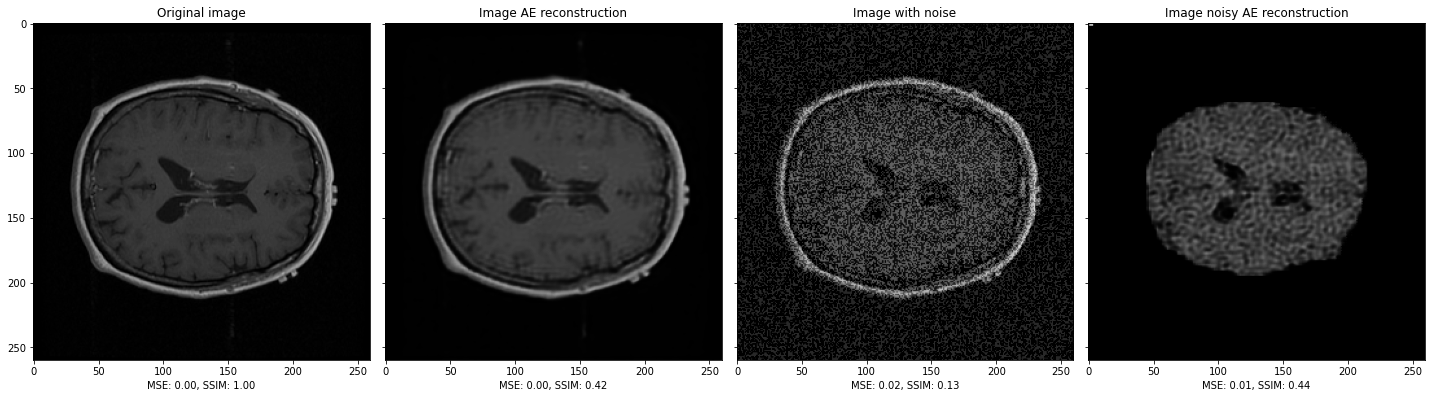

In [89]:
SSIM(imgages[:20],10)

In [ ]:
pip install annoy

     |████████████████████████████████| 646 kB 4.9 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391628 sha256=e562ed69e6a7514e3770f0f8e578b61f764617124ce6b49e12086b275aab89d9
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


In [ ]:
from annoy import AnnoyIndex
from google.colab import files

In [ ]:
#vector length is 65x65x128
encoding_vector_length = 540800
annoy_file_name = '/content/gdrive/MyDrive/Data/Weights/temp.annoy.index'
num_trees = 20
model_save_path = '/content/gdrive/MyDrive/Data/Weights/encoder_mri.h5'
image_size = 260

In [ ]:
def get_encodings(model_path, images, encoding_vector_length):
  encoder = Model(input_layer, latent_view)
  encoder.load_weights(model_path)
  encoding_vectors = encoder.predict(images)
  return np.array(encoding_vectors).reshape(-1, encoding_vector_length)

In [ ]:
def build_annoy_index(encoding_dim, num_trees, annoy_index_file, encodings):   
  ann = AnnoyIndex(encoding_dim)   
  for index, encoding in enumerate(encodings):
    ann.add_item(index, encoding)    
  
  ann.build(num_trees)
  ann.save(annoy_file_name)
  files.download(annoy_file_name)
  print("Created Annoy Index Successfully")
  return ann

In [ ]:
encodings = get_encodings(model_save_path, images, encoding_vector_length)

In [ ]:
from numpy import load
encodings = load('/content/gdrive/MyDrive/encodings.npy')

In [ ]:
len(encodings)

2040

In [ ]:
build_annoy_index(encoding_vector_length, num_trees, annoy_file_name, encodings)

In [ ]:
from google.colab import files
files.download('/content/encodings.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def get_similar_images(image, n_similar=5): 
  encoding = get_encodings(model_save_path,image.reshape(-1, image_size, image_size,1), encoding_vector_length)
  saved_ann = AnnoyIndex(encoding_vector_length)
  saved_ann.load(annoy_file_name)

  nn_indices = saved_ann.get_nns_by_vector(encoding[0], n_similar)  
  print("Similar images are")
  fig = plt.figure(figsize=(20,120))
  fig.add_subplot(1,6,1)
  plt.xticks([])
  plt.yticks([])
  plt.title("Sample image",fontsize='15')
  plt.imshow(image.reshape(260,260), cmap='Greys_r')
  for i, index in enumerate(nn_indices,1):
    image = images[index].reshape(260,260)
    fig.add_subplot(1,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"{i}, index: {index}",fontsize='15')
    plt.imshow(image, cmap='Greys_r')

In [ ]:
def get_similar_indices(image, n_similar): 
  encoding = get_encodings(model_save_path,image.reshape(-1, image_size, image_size,1), encoding_vector_length)
  saved_ann = AnnoyIndex(encoding_vector_length)
  saved_ann.load(annoy_file_name)

  nn_indices = saved_ann.get_nns_by_vector(encoding[0], n_similar,k)
  return nn_indices

In [ ]:
def get_similar_patient(slices):
  simpatients = {}
  for img in slices:
    indices = get_similar_indices(img,100)
    for n in indices:
      key = (n//20) + 1
      if key in simpatients:
        simpatients[key] += 1
      else:
        simpatients[key] = 1
  
  simpatients = sorted(list(simpatients.items()), key=lambda tup: tup[1])
  simpatients.reverse()
  print(simpatients)

  return simpatients
  # return (max(simpatients),simpatients.get(max(simpatients)))

In [ ]:
def similar_patients(input_file_path):
  simpatients = {}
  encodings = get_encodings(model_save_path, images, encoding_vector_length)
  slices = image_preprocessing(load_slices(input_file_path,256))
  for n in range(0,5):
    build_annoy_index(encoding_vector_length, num_trees, annoy_file_name, encodings)
    tmp = get_similar_patient(slices)
    simpatients[tmp[0]] = tmp[1]
    index = tmp[0]*20
    del encodings[index-20,index]
  simpateints = get_similar_patient(slices)

In [ ]:
!unzip '/content/gdrive/MyDrive/Data/TEST-LGG.zip'

Archive:  /content/gdrive/MyDrive/Data/TEST-LGG.zip
   creating: TEST-LGG/
  inflating: TEST-LGG/LGG_AX-T1-POST_AXIAL_T1_POST_GD_19830723050848_9.nii.gz  
  inflating: TEST-LGG/LGG_AX-T1-POST_POST_AX_T1_3MM_19980711111320_1303.nii.gz  


In [ ]:
ff3 = glob.glob('/content/TEST-LGG/*')

In [ ]:
test = image_preprocessing(load_images(ff3,256,20))

In [ ]:
test_img = test[20:40]

In [ ]:
test_img.shape

(20, 260, 260, 1)

In [ ]:
simpatients = get_similar_patient(test_img)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.
  This is separate from the ipykernel package so we can avoid doing imports until


[(21, 400), (27, 400), (100, 342), (2, 292), (20, 181), (34, 152), (16, 122), (54, 111)]


In [ ]:
display_patients(simpatients,test_img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def display_patients(simpatients,slices):

  fig = plt.figure(figsize=(24,92), tight_layout='true')
  for index in range(len(slices)):
    #image = skTrans.resize(slices[index], (128, 128), order=1, preserve_range=True)
    image = slices[index].reshape(260,260)
    fig.add_subplot(20,6,index*6+1)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(index+1,fontsize='40',rotation=0,labelpad=35)
    if index == 0:
      plt.title(f"Input patient",fontsize='15',pad=20)
    plt.imshow(image, cmap='Greys_r')

  nsim = 0
  tumorType = None
  for p,f in simpatients[:5]:
    nsim += 1
    slicep = (p-1)*20
    if p > 80:
      tumorType = "LGG"
    else:
      tumorType = "GBM"
    for index in range(slicep,slicep+20):
      #image = skTrans.resize(images[index], (128, 128), order=1, preserve_range=True)
      image = images[index].reshape(260,260)
      fig.add_subplot(20,6,(index-slicep)*6+1+nsim)
      plt.xticks([])
      plt.yticks([])
      if index == slicep:
        plt.title(f"{nsim}: Patient {p} ({tumorType}) {round(f/(20*100),3)}",fontsize='15',pad=20)
      plt.imshow(image, cmap='Greys_r')

  plt.savefig('similarpatients.png')
  files.download('similarpatients.png')

In [ ]:
display_patients(simpatients,test_img)

Output hidden; open in https://colab.research.google.com to view.